In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
import seaborn as sns

import umap
import math

import warnings
warnings.filterwarnings('ignore')

c:\Users\Mohamed\anaconda3\envs\coursera\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data)
data.columns = cancer.feature_names
data['target'] = cancer.target

In [3]:
data.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [4]:
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [169]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(x, y, w, b):

    z = np.dot(w,x.T) + b
    y_hat = sigmoid(z)
    cost = -np.mean(y * np.log(y_hat + 1e-9) + (1-y) * np.log(1 - y_hat + 1e-9))

    return  cost

def cost_function_regularization(x, y, w, b, lambda_=1):
    m, n = x.shape
    cost_without_reg = cost_function(x, y, w, b)
    reg_cost = (lambda_/(2*m))*sum(w**2)    
    return cost_without_reg + reg_cost

def derivative_cost_function(x, y, w, b):
    m, n = x.shape
    z = np.dot(w,x.T) + b
    err = sigmoid(z) - y
    d_cost_w = np.dot(x.T, err)/m
    d_cost_b = np.mean(err)

    return d_cost_w, d_cost_b

def derivative_cost_function_regularization(x, y, w, b, lambda_=1):
    m, n = x.shape
    z = np.dot(w,x.T) + b
    err = sigmoid(z) - y
    d_cost_w = (np.dot(x.T, err)/m) + (lambda_ * w)/m
    d_cost_b = np.mean(err)

    return d_cost_w, d_cost_b

def gradient_descent(x, y, learning_rate, epocs=10):
    m, n = x.shape
    w = np.zeros((n,))
    b = 0

    learning_curve = []
    w_history = []

    for i in range(epocs):
        d_cost_w, d_cost_b = derivative_cost_function_regularization(x, y, w, b)
        w = w - learning_rate * d_cost_w
        b = b - learning_rate * d_cost_b

        learning_curve.append(cost_function_regularization(x, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(epocs/10) == 0 or i == (epocs-1):
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(learning_curve[-1]):8.2f}, w {w if n==2 else None}, b {b}")

    return w, b, learning_curve, w_history


def predict(x, w, b, threshold=0.5):
    y_hat = sigmoid(np.dot(x,w) + b)
    y_hat = (y_hat >= threshold).astype(int)
    return y_hat

def predict_proba(x, w, b):
    y_proba = np.zeros((x.shape[0], 2))
    y_hat = sigmoid(np.dot(x,w) + b)
    y_proba[:, 1] = y_hat
    y_proba[:, 0] = 1 - y_hat
    return y_proba

def accuracy(y, y_hat):
    accuracy = np.sum(y == y_hat) / len(y)
    return accuracy

def normalize(x):
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)


def plot_decision_boundary(X, Y, w, b):
    c = -b/w[1]
    m = -w[0]/w[1]

    xmin, xmax = X[:,0].min(), X[:,0].max()
    ymin, ymax = X[:,1].min(), X[:,1].max()
    xd = np.array([xmin, xmax])
    yd = m * xd + c

    plt.plot(xd, yd, 'k', lw=1, ls='--')
    plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
    plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

    plt.scatter(*X[Y==0].T, s=8, alpha=0.5)
    plt.scatter(*X[Y==1].T, s=8, alpha=0.5)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')

def plot_sigmoid(X, Y, w, b):
    plt.scatter(X, Y, s=8, alpha=0.5)
    axis_x = np.arange(X.min(), X.max(), 0.1)
    axis_y = sigmoid((np.dot(axis_x, w.T) + b))
    sns.lineplot(x=axis_x, y=axis_y)
    
def plot_results(X, y, learning_curve, w, b):
    plt.figure(figsize = (24,6))

    plt.subplot(1,3,1)
    sns.lineplot(x=np.arange(len(learning_curve)),y=learning_curve)
    plt.title('Learning Curve', fontsize = 20)

    if X.shape[1] == 2:
        plt.subplot(1,3,2)
        plot_decision_boundary(X, y, w, b)
        plt.title('Decision boundary', fontsize = 20)

        plt.subplot(1,3,3)
        plot_sigmoid(X[:,0], y, w[0], b)
        plt.title('Sigmoid function (one feature)', fontsize = 20)

In [140]:
X = data.drop("target", axis=1).to_numpy()[:,:2]
y = data['target'].to_numpy()

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size = 0.3, random_state = 31)

In [142]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [143]:
learning_rate = 0.01
epocs = 1000
w, b, learning_curve, history_f_function = gradient_descent(X_train, y_train, learning_rate, epocs)

Iteration    0: Cost     0.69, w [-0.00355443 -0.00188036], b 0.0012814070351758794
Iteration  100: Cost     0.56, w [-0.3121218  -0.15679152], b 0.11456907676973649
Iteration  200: Cost     0.48, w [-0.54949337 -0.26286894], b 0.20345520243935852
Iteration  300: Cost     0.44, w [-0.74006332 -0.33856862], b 0.2742814121012115
Iteration  400: Cost     0.40, w [-0.89864118 -0.39485486], b 0.33170003874679915
Iteration  500: Cost     0.38, w [-1.03419468 -0.43818354], b 0.37897713988669235
Iteration  600: Cost     0.36, w [-1.15242431 -0.47250652], b 0.4184148844212067
Iteration  700: Cost     0.35, w [-1.25714438 -0.50035174], b 0.4516701229187492
Iteration  800: Cost     0.34, w [-1.35102389 -0.52340166], b 0.4799643406373193
Iteration  900: Cost     0.33, w [-1.43600182 -0.54281469], b 0.5042188578312917
Iteration  999: Cost     0.33, w [-1.51278909 -0.55925756], b 0.5249481851929219


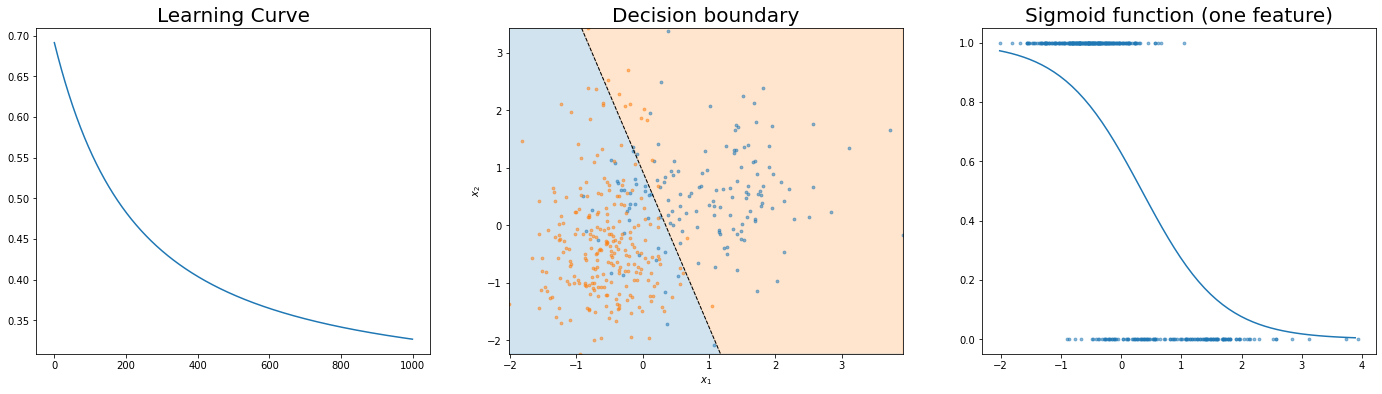

In [170]:
plot_results(X_train, y_train, learning_curve, w, b)

In [145]:
y_hat = predict(X_train, w, b)
accuracy(y_train, y_hat)

0.8768844221105527

In [146]:
y_hat = predict(X_test, w, b)
accuracy(y_test, y_hat)

0.8947368421052632

## Logistic Regression Class

In [50]:
class LogisticRegression:

    def __init__(self, epocs=100) -> None:
        self.epocs = epocs
        self.w = None
        self.b = 0
        self.learning_curve = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _cost_function(self, x, y):

        z = np.dot(self.w,x.T) + self.b
        y_hat = self._sigmoid(z)
        cost = -np.mean(y * np.log(y_hat + 1e-9) + (1-y) * np.log(1 - y_hat + 1e-9))

        return cost

    def _derivative_cost_function(self, X, y):

        z = np.dot(self.w,X.T) + self.b
        err = self._sigmoid(z) - y
        d_cost_w = np.dot(X.T, err)/X.shape[0]
        d_cost_b = np.mean(err)

        return d_cost_w, d_cost_b

    def fit(self, X, y, learning_rate=1e-3) -> None:
        m, n = X.shape
        self.w = np.zeros((n,))
        self.b = 0

        for _ in range(self.epocs):
            d_cost_w, d_cost_b = self._derivative_cost_function(X, y)
            self.w = self.w - learning_rate * d_cost_w
            self.b = self.b - learning_rate * d_cost_b

            self.learning_curve.append(self._cost_function(X, y))

    def predict(self, X, threshold=0.5):
        y_hat = self._sigmoid(np.dot(self.w,X.T) + self.b)
        y_hat = (y_hat >= threshold).astype(int)
        return y_hat

    def predict_proba(self, X):
        y_proba = np.zeros((X.shape[0], 2))
        y_hat = self._sigmoid(np.dot(self.w,X.T) + self.b)
        y_proba[:, 1] = y_hat
        y_proba[:, 0] = 1 - y_hat
        return y_proba

    def accuracy(self, y, y_hat):
        accuracy = np.sum(y == y_hat) / len(y)
        return accuracy


### Data

In [51]:
X = data.drop("target", axis=1).to_numpy()[:,:2]
y = data['target'].to_numpy()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size = 0.3, random_state = 31)

In [53]:
X_train = normalize(X_train)
X_test = normalize(X_test)

### Training

In [57]:
lr = LogisticRegression(epocs=1000)
lr.fit(X_train, y_train)

### Evaluation

In [58]:
y_hat = lr.predict(X_train)
print("Accuracy train:", lr.accuracy(y_train, y_hat))
y_hat = lr.predict(X_test)
print("Accuracy test:", lr.accuracy(y_test, y_hat))

Accuracy train: 0.871859296482412
Accuracy test: 0.9005847953216374


### Learning Curve and Decision boundary

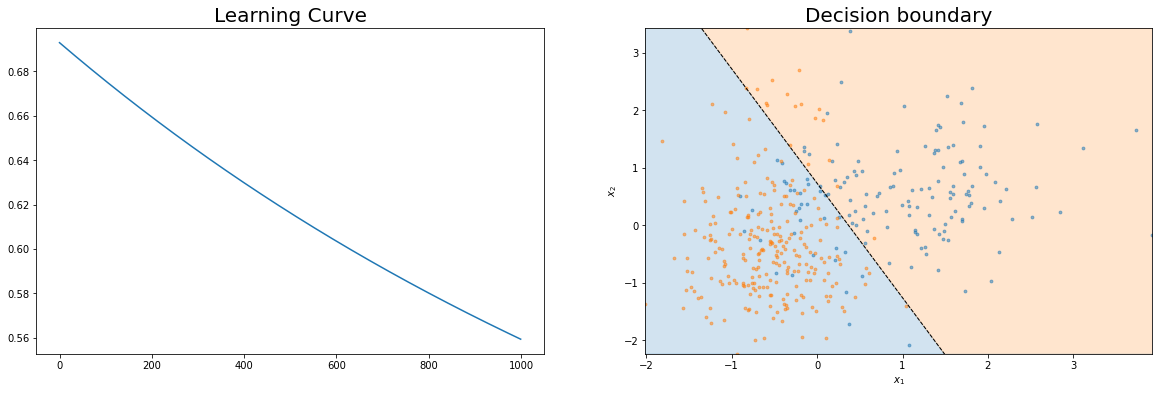

In [59]:
plot_results(X_train, y_train, lr.learning_curve, lr.w, lr.b)